## Import

In [1]:
!pip install    iterative-stratification    cmaes    -q

In [2]:
import warnings
warnings.filterwarnings("ignore")

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
from functools import partial
import tensorflow as tf
import seaborn as sns
import pandas as pd
import random as rn
import numpy as np
import sklearn
import os


rn.seed(279)
tf.random.set_seed(23)
os.environ["PYTHONHASHSEED"] = "325"

2024-03-25 00:52:42.257795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 00:52:42.257939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 00:52:42.260748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Read in the data

In [3]:
sub_df   = pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
X_test  = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
org_df   = pd.read_csv('/kaggle/input/faulty-steel-plates/faults.csv')

In [4]:
train_df = train_df.drop(["id"], axis=1)
X_test_ids = X_test["id"]
X_test = X_test.drop(["id"], axis=1)
train_df_combined = pd.concat([train_df, org_df], ignore_index=True)
train_df_combined.shape

(21160, 34)

In [5]:
train_df_combined.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


## Understand the features

We have 7 lables in our y_train, listed as follows:

- Pastry: Pastry refers to small patches or irregularities on the surface of the steel plate, typically caused by imperfections in the manufacturing process or handling during transport. These imperfections can affect the surface smoothness and appearance of the steel plate.

- Z_Scratch: Z-scratches are narrow scratches or marks on the surface of the steel plate that run parallel to the rolling direction. Various factors, such as handling, machining, or contact with abrasive materials during production or transportation, can cause these scratches.

- K_Scratch: K-scratches are similar to Z-scratches but run perpendicular to the rolling direction. They can also be caused by handling, machining, or contact with abrasive materials during manufacturing or transportation processes.

- Stains: Stains refer to discolored or contaminated areas on the surface of the steel plate. These stains can result from various sources, such as rust, oil, grease, or other foreign substances that come into contact with the steel surface during processing, storage, or handling.

- Dirtiness: Dirtiness indicates the presence of dirt or particulate matter on the surface of the steel plate. This can include various types of debris or contaminants that accumulate during manufacturing, handling, or storage processes.

- Bumps: Bumps are raised or protruding areas on the surface of the steel plate. These can be caused by irregularities in the manufacturing process, such as uneven rolling or cooling, or by physical damage during handling or transportation.

- Other_Faults: This category likely encompasses a broader range of faults or defects not explicitly categorized in the other fault types listed. It could include various types of surface imperfections, irregularities, or abnormalities that affect the quality or usability of the steel plate.

Information about the features:

The dataset "Steel Plates Faults" contains 27 features that describe each fault in detail. Here is an explanation of some of the features based on the information gathered from the search results:

- Location Features:

X_Minimum: The minimum x-coordinate of the fault.
X_Maximum: The maximum x-coordinate of the fault.
Y_Minimum: The minimum y-coordinate of the fault.
Y_Maximum: The maximum y-coordinate of the fault.

- Size Features:

Pixels_Areas: Area of the fault in pixels.
X_Perimeter: Perimeter along the x-axis of the fault.
Y_Perimeter: Perimeter along the y-axis of the fault.

- Luminosity Features:

Sum_of_Luminosity: Sum of luminosity values in the fault area.
Minimum_of_Luminosity: Minimum luminosity value in the fault area.
Maximum_of_Luminosity: Maximum luminosity value in the fault area.

- Material and Index Features:

TypeOfSteel_A300: Type of steel (A300).
TypeOfSteel_A400: Type of steel (A400).
Steel_Plate_Thickness: Thickness of the steel plate.
Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, Outside_Global_Index: Various index values related to edges and geometry.

- Logarithmic Features:

LogOfAreas: Logarithm of the area of the fault.
Log_X_Index, Log_Y_Index: Logarithmic indices related to X and Y coordinates.
Statistical Features:

- Orientation_Index: Index describing orientation.
- Luminosity_Index: Index related to luminosity.
- SigmoidOfAreas: Sigmoid function applied to areas.

Conclusion: We have two categorical features here! `TypeOfSteel_A300` and `TypeOfSteel_A400`

### something that I can try

1. MultiOutputClassifier 
https://www.kaggle.com/code/fchmiel/xgboost-baseline-multilabel-classification
2. Find wieght for ensemble with Optuna

## EDA

In [6]:
train_df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21160 entries, 0 to 21159
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              21160 non-null  int64  
 1   X_Maximum              21160 non-null  int64  
 2   Y_Minimum              21160 non-null  int64  
 3   Y_Maximum              21160 non-null  int64  
 4   Pixels_Areas           21160 non-null  int64  
 5   X_Perimeter            21160 non-null  int64  
 6   Y_Perimeter            21160 non-null  int64  
 7   Sum_of_Luminosity      21160 non-null  int64  
 8   Minimum_of_Luminosity  21160 non-null  int64  
 9   Maximum_of_Luminosity  21160 non-null  int64  
 10  Length_of_Conveyer     21160 non-null  int64  
 11  TypeOfSteel_A300       21160 non-null  int64  
 12  TypeOfSteel_A400       21160 non-null  int64  
 13  Steel_Plate_Thickness  21160 non-null  int64  
 14  Edges_Index            21160 non-null  float64
 15  Em

In [7]:
train_df_combined.describe().T

,count,mean,std,min,25%,50%,75%,max
X_Minimum,21160.0,6.971301e+02,5.320546e+02,0.0000,50.0000,7.540000e+02,1.145000e+03,1.705000e+03
X_Maximum,21160.0,7.413922e+02,5.011601e+02,4.0000,214.0000,7.720000e+02,1.161000e+03,1.713000e+03
Y_Minimum,21160.0,1.831495e+06,1.892922e+06,6712.0000,639490.0000,1.378585e+06,2.339627e+06,1.298766e+07
Y_Maximum,21160.0,1.828639e+06,1.886266e+06,6724.0000,639507.0000,1.378261e+06,2.336466e+06,1.298769e+07
Pixels_Areas,21160.0,1.703241e+03,3.884801e+03,2.0000,88.0000,1.690000e+02,6.590000e+02,1.526550e+05
X_Perimeter,21160.0,9.714074e+01,1.925100e+02,2.0000,15.0000,2.500000e+01,6.700000e+01,1.044900e+04
Y_Perimeter,21160.0,6.585246e+01,1.611876e+02,1.0000,14.0000,2.400000e+01,6.200000e+01,1.815200e+04
Sum_of_Luminosity,21160.0,1.931736e+05,4.489348e+05,250.0000,9778.0000,1.840200e+04,6.841600e+04,1.159141e+07
Minimum_of_Luminosity,21160.0,8.478459e+01,2.912134e+01,0.0000,68.0000,9.000000e+01,1.050000e+02,2.030000e+02
Maximum_of_Luminosity,21160.0,1.287892e+02,1.467294e+01,37.0000,124.0000,1.270000e+02,1.350000e+02,2.530000e+02


In [8]:
X_train = train_df_combined.drop(columns=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
    'Dirtiness', 'Bumps', 'Other_Faults'], axis=1)
y_train = train_df_combined[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
    'Dirtiness', 'Bumps', 'Other_Faults']]
X_train.shape

(21160, 27)

#### Examine multilabels

There are the posts that I found super useful:

https://www.kaggle.com/competitions/playground-series-s4e3/discussion/485350#2709646

In [9]:
# count how many percentages of the observations have multiple labels
# Turns out there could be multiple labels for one observation, but the percentage is low: 0.09%
count_multi_labels = (np.sum(y_train, axis=1) > 1).sum()
count_multi_labels/y_train.shape[0] * 100

0.09924385633270322

In [10]:
# calculate the percentage of observations that don't have any labels
count_no_labels = (np.sum(y_train, axis=1) == 0).sum()
count_no_labels/y_train.shape[0] * 100

3.8657844990548202

In [11]:
# There are near 4% of the datapoints have 0 labels or more than 1 labels
(count_multi_labels + count_no_labels) / y_train.shape[0] * 100

3.965028355387524

In [12]:
X_train['TypeOfSteel_A300'].value_counts()

TypeOfSteel_A300
0    12644
1     8516
Name: count, dtype: int64

In [13]:
X_train['TypeOfSteel_A400'].value_counts()

TypeOfSteel_A400
1    12625
0     8535
Name: count, dtype: int64

## Feature Engineering

In [14]:
# Delete the observations that don't have any labels
index_no_label = np.where(y_train.sum(axis=1) == 0)[0]
X_train = X_train.drop(index_no_label, axis=0)
y_train = y_train.drop(index_no_label, axis=0)

In [15]:
# Examine the rows with more than two labels
index_two_labels = np.where(y_train.sum(axis=1) > 1)[0]
train_df.iloc[index_two_labels]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
603,980,992,516427,516436,82,14,10,9584,113,143,...,-0.5294,-0.0148,0.2482,0,0,0,0,0,0,1
718,1338,1348,1009876,1009888,121,13,18,12602,81,117,...,0.2000,-0.2423,0.2914,0,0,0,0,0,1,0
3416,860,868,1248833,1248844,107,23,18,11890,84,124,...,0.5556,-0.2125,0.3068,0,0,0,0,0,0,1
4230,995,1015,5367324,5367377,204,27,32,18774,108,134,...,0.0909,-0.0366,0.6268,0,0,0,0,0,0,1
4342,981,989,75233,75234,55,13,15,5226,84,119,...,0.6667,-0.2267,0.2150,0,0,0,0,0,1,0
4470,559,571,798878,798912,127,27,13,13943,99,126,...,-0.0500,-0.1403,0.3977,0,0,0,0,0,0,1
6173,41,212,949136,949144,6181,263,141,686356,41,126,...,-0.6229,-0.1926,1.0000,0,0,1,0,0,0,0
7273,476,493,1519629,1519634,63,12,8,8355,120,148,...,-0.3000,0.0088,0.1753,0,0,0,0,0,0,1
7728,408,415,828904,828914,67,12,12,7842,115,132,...,0.0000,-0.0387,0.2288,0,0,0,0,0,0,1
8170,501,522,1046616,1046624,101,31,18,12693,103,133,...,-0.7222,-0.1157,0.3509,0,0,0,0,0,1,0


Conclusion: all the rows that have more than one labels have labels as "K_Scatch", so to get rid of this noise, let's just change all these 21 observations to be labelled as "K_Scatch".

In [16]:
y_train.iloc[index_two_labels] = 0
y_train.loc[index_two_labels, "K_Scatch"] = 1

In [17]:
# check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
df = X_train.copy()
df = sm.add_constant(df.select_dtypes(include=[np.number]))
vif = pd.DataFrame()
vif["Variable"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif

,Variable,VIF
0,const,1963.394753
1,X_Minimum,118.481400
2,X_Maximum,105.201803
3,Y_Minimum,18.669326
4,Y_Maximum,18.678913
5,Pixels_Areas,5.747082
6,X_Perimeter,8.799525
7,Y_Perimeter,4.224753
8,Sum_of_Luminosity,3.906513
9,Minimum_of_Luminosity,6.476428


In [18]:
highly_correlated_variable = []
for index,row in vif.iterrows():
    if row['VIF']>6.5:
        highly_correlated_variable.append(row['Variable'])
highly_correlated_variable.remove('const')
print(highly_correlated_variable)

['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'X_Perimeter', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_X_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']


X_Minimum and X_Maximum are correlated because they are both related to the position of an object on the X-axis. So does 'Y_Minimum' and 'Y_Maximum'. 'TypeOfSteel_A300' and 'TypeOfSteel_A400' are correlated because they are highly likely won't co-exist.

In [19]:
class Preprocess(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return 
    
    def fit_transform(self, X):
        epsilon = 1e-6 # Avoid Division by Zero

        # Location Features
        X['X_Distance'] = X['X_Maximum'] - X['X_Minimum']
        X['Y_Distance'] = X['Y_Maximum'] - X['Y_Minimum']
        
        # Luminosity Feature
        X['Luminosity_range'] = X['Maximum_of_Luminosity'] - X['Minimum_of_Luminosity']

        # Density Feature
        X['Density'] = X['Pixels_Areas'] / (X['X_Perimeter'] + X['Y_Perimeter'])

        # Relative Perimeter Feature
        X['Relative_Perimeter'] = X['X_Perimeter'] / (X['X_Perimeter'] + X['Y_Perimeter'] + epsilon)
# Circularity Feature
        X['Circularity'] = X['Pixels_Areas'] / (X['X_Perimeter'] ** 2)

        # Symmetry Index Feature
        X['Symmetry_Index'] = np.abs(X['X_Distance'] - X['Y_Distance']) / (X['X_Distance'] + X['Y_Distance'] + epsilon)

        # Color Contrast Feature
        X['Color_Contrast'] = X['Maximum_of_Luminosity'] - X['Minimum_of_Luminosity']

        # Combined Geometric Index Feature
        X['Combined_Geometric_Index'] = X['Edges_Index'] * X['Square_Index']

        # Interaction Term Feature
        X['X_Distance*Pixels_Areas'] = X['X_Distance'] * X['Pixels_Areas']

        # Additional Features
        X['sin_orientation'] = np.sin(X['Orientation_Index'])
        X['Edges_Index2'] = np.exp(X['Edges_Index'] + epsilon)
        X['X_Maximum2'] = np.sin(X['X_Maximum'])
        X['Y_Minimum2'] = np.sin(X['Y_Minimum'])
        X['Aspect_Ratio_Pixels'] = np.where(X['Y_Perimeter'] == 0, 0, X['X_Perimeter'] / X['Y_Perimeter'])
        X['Aspect_Ratio'] = np.where(X['Y_Distance'] == 0, 0, X['X_Distance'] / X['Y_Distance'])
        
        # Exponentiate the log scale features
#         X['Areas'] = np.exp(X['LogOfAreas'])
#         X['X_Index'] = np.exp(X['Log_X_Index'])
#         X['Y_Index'] = np.exp(X['Log_Y_Index'])

        # Normalized Steel Thickness Feature
        X['Normalized_Steel_Thickness'] = (X['Steel_Plate_Thickness'] - X['Steel_Plate_Thickness'].min()) / (X['Steel_Plate_Thickness'].max() - X['Steel_Plate_Thickness'].min())

        # Logarithmic Features
        X['Log_Perimeter'] = np.log(X['X_Perimeter'] + X['Y_Perimeter'] + epsilon)
        X['Log_Luminosity'] = np.log(X['Sum_of_Luminosity'] + epsilon)
        X['Log_Aspect_Ratio'] = np.log(X['Aspect_Ratio'] ** 2 + epsilon)

        # Statistical Features
        X['Combined_Index'] = X['Orientation_Index'] * X['Luminosity_Index']
        X['Sigmoid_Areas'] = 1 / (1 + np.exp(-X['LogOfAreas'] + epsilon))
        return X

X_train = Preprocess().fit_transform(X_train)
X_test = Preprocess().fit_transform(X_test)

In [20]:
# Define numerical and categorical columns
features=list(X_train)
num_cols = features.copy()
cat_cols = ["TypeOfSteel_A300","TypeOfSteel_A400"]
for f in cat_cols:
    num_cols.remove(f)

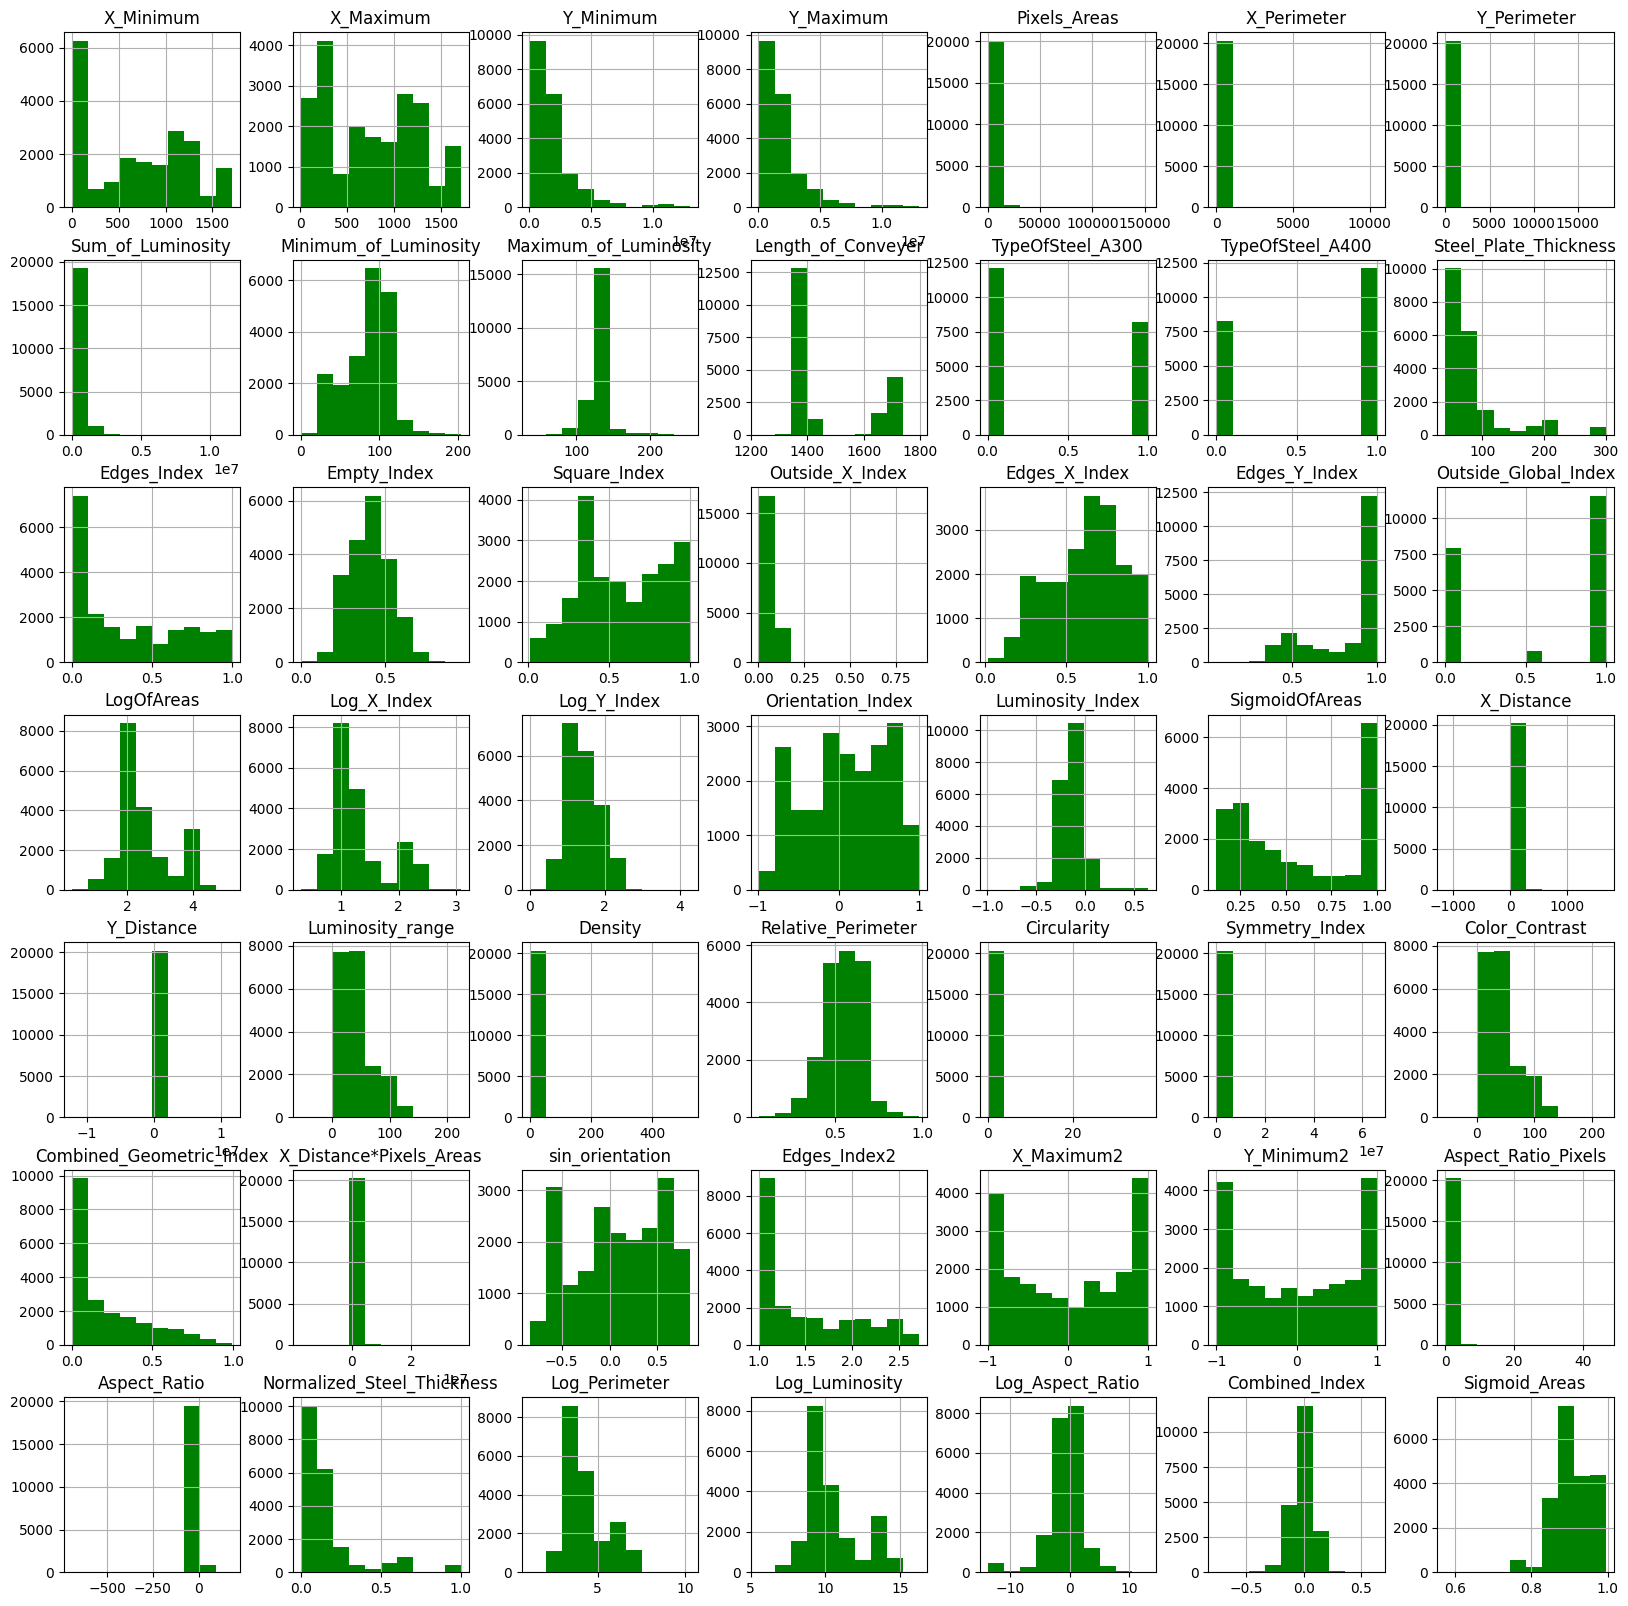

In [21]:
X_train.hist(figsize=(20,20),color = 'green')
plt.show()

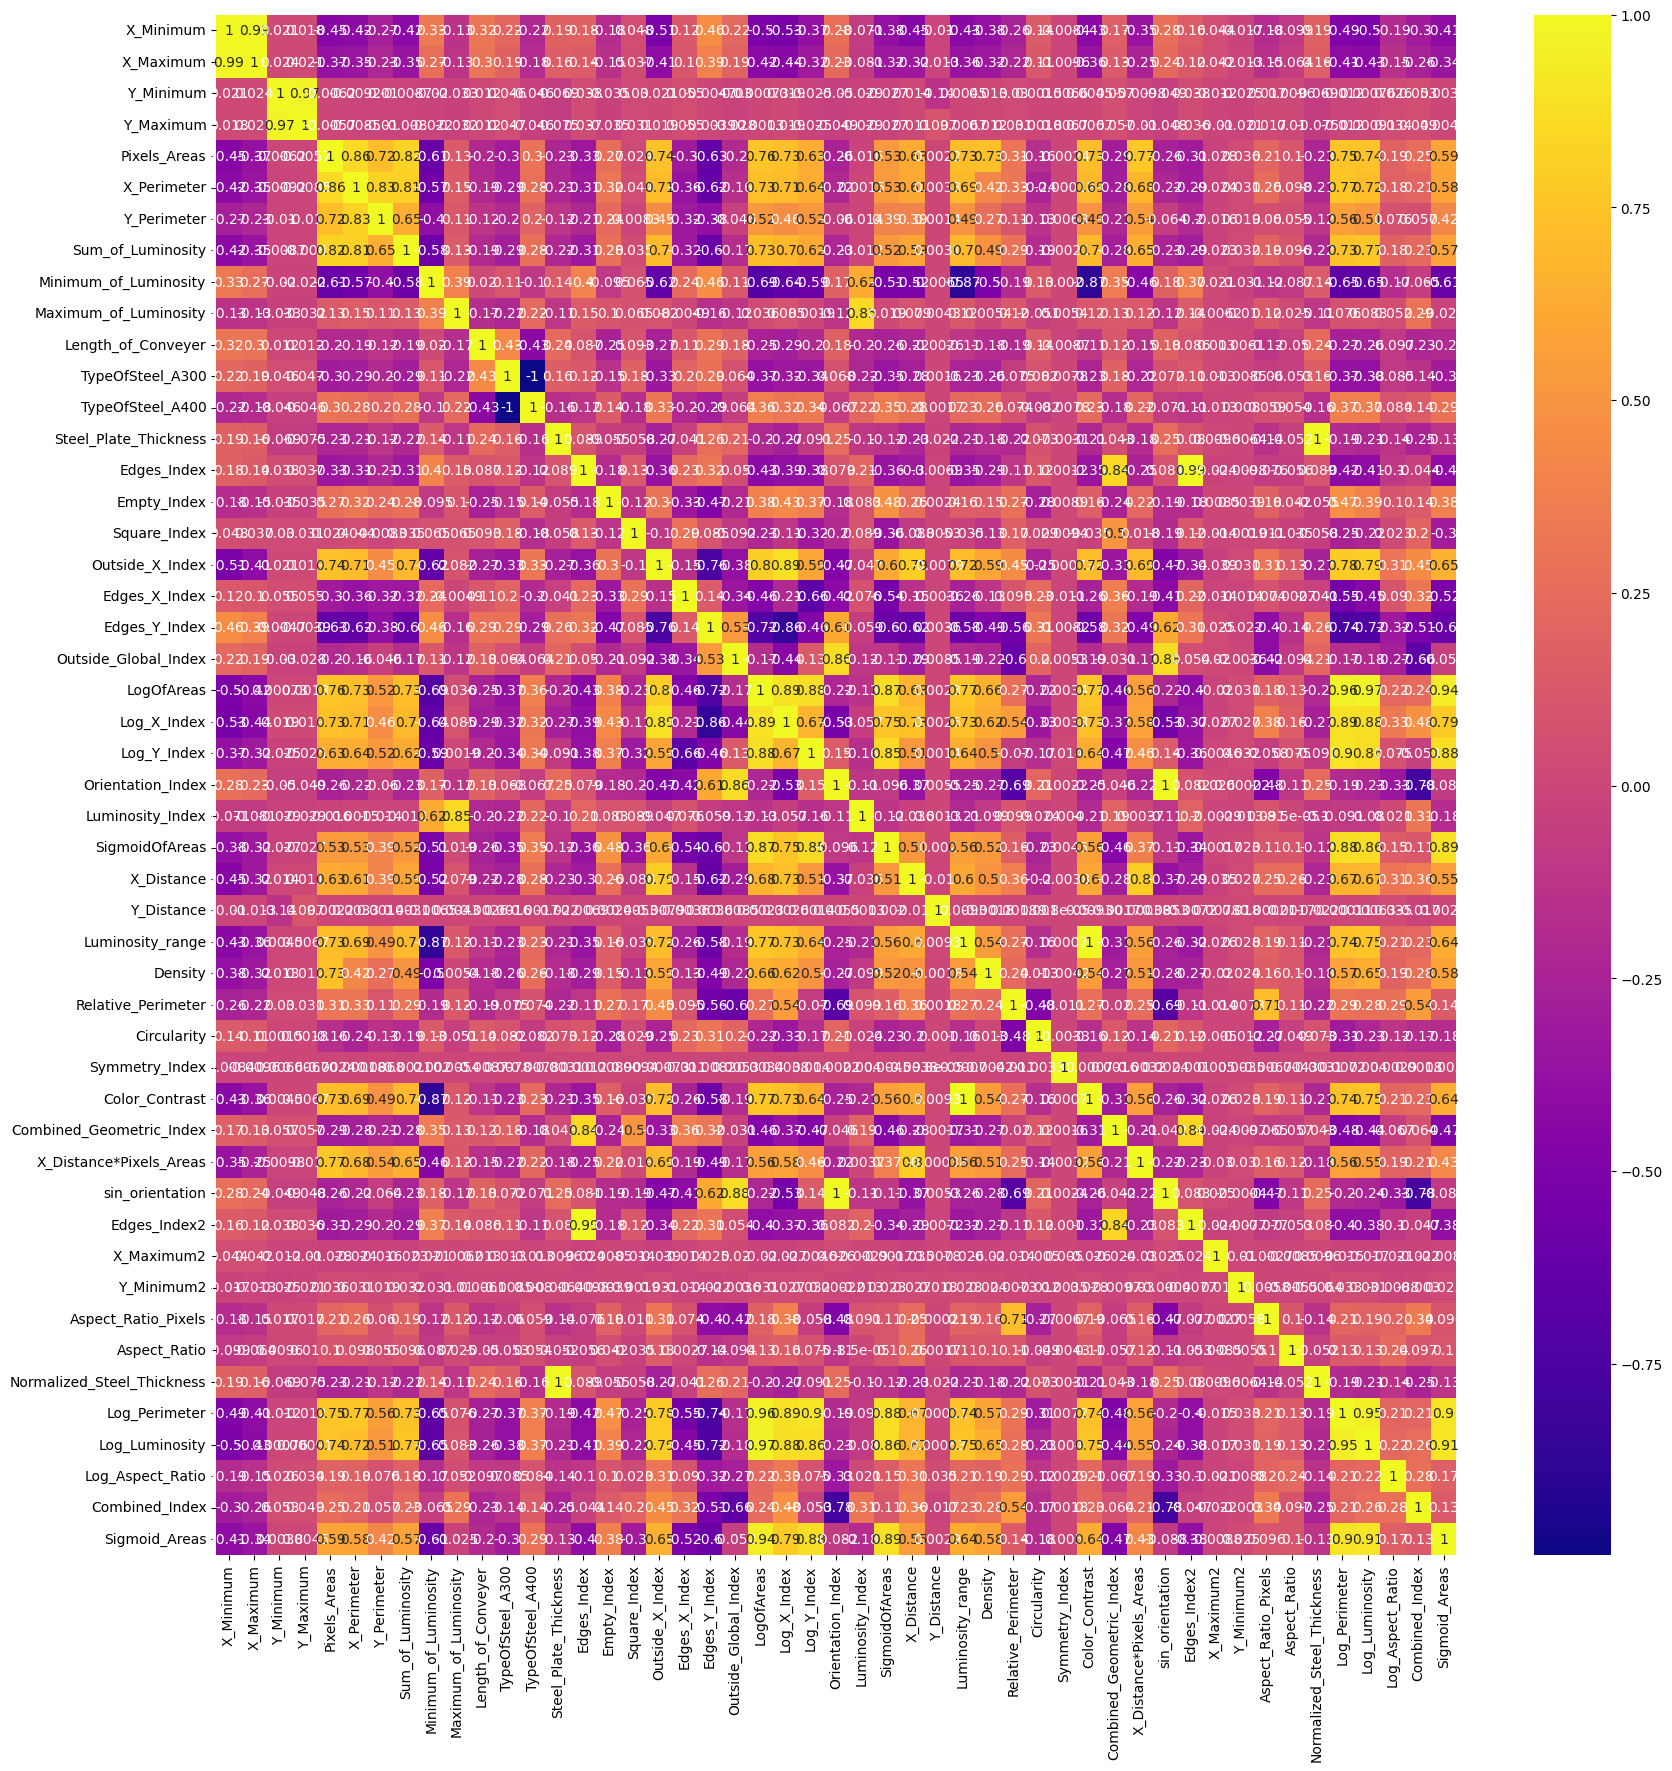

In [22]:
plt.figure(figsize=(20,20))
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True,cmap="plasma")
plt.show()

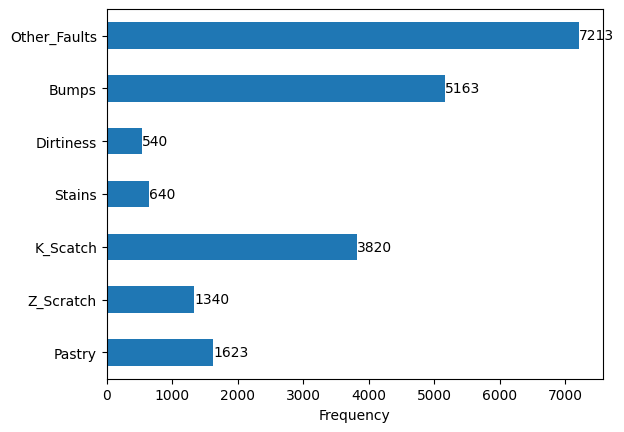

In [23]:
# counts of targets
ax = y_train.sum(axis=0).plot(kind='barh')
ax.bar_label(ax.containers[0], label_type='edge')
plt.xlabel('Frequency')
plt.show()

## Feature Selection

**1. Dropping Constant Features using VarianceThreshold**

In [24]:
from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0.10) 
var_thr.fit(X_train)

var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False, False])

In [25]:
concol = [column for column in X_train.columns if column not in X_train.columns[var_thr.get_support()]]
concol

['Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Luminosity_Index',
 'Relative_Perimeter',
 'Combined_Geometric_Index',
 'Normalized_Steel_Thickness',
 'Combined_Index',
 'Sigmoid_Areas']

In [26]:
X_train = X_train.drop(columns=concol, axis=1)
X_test = X_test.drop(columns=concol, axis=1)

## Adversarial Validation

In [27]:
from sklearn.ensemble import RandomForestClassifier

def adversarial_validation(X_train,X_test):
    X_train["Adv_Val_label"] = 0
    X_test["Adv_Val_label"]  = 1
    all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)
    
    # shuffle
    all_data = all_data.sample(frac=1)
    rf = RandomForestClassifier(random_state=42,max_depth=2,class_weight='balanced')

    X = all_data.drop(['Adv_Val_label'], axis=1).fillna(-1)
    y = all_data['Adv_Val_label']

    rf.fit(X, y)

    auc_score = roc_auc_score(y, rf.predict_proba(X)[:,1])
    print(auc_score)

adversarial_validation(X_train, X_test)

0.544138813383387


The train set doesn't distinguish from test set siginificantly as we have the auc score close to 0.5. This result is desirable and now we are ready for model building. 

## Models

In [50]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
target_cols = y_train.columns.to_list()

In [51]:
CFG = {
    'RANDOM_SEED':123,
    'n_splits':10,
}

In [52]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits = CFG['n_splits'])
y_train_2 = y_train.copy()

def cross_val_model(estimators, X_train_scaled, y_train_2, X_test_scaled, target_col, cv = skf, verbose = True):
    '''
        estimators : pipeline consists preprocessing, encoder & model
        cv : Method for cross validation (default: StratifiedKfold)
        verbose : print train/valid score (yes/no)
    '''
    
    valid_predictions = np.zeros((len(X_train_scaled), 2))
    test_predictions = np.zeros((len(X_test_scaled), 2))
    
    val_scores, train_scores = [], []
    for fold, (train_ind, valid_ind) in enumerate(skf.split(X_train_scaled, y_train_2)):
        model = clone(estimators)
        X_train = X_train_scaled.iloc[train_ind]
        y_train = y_train_2.iloc[train_ind]

        X_valid = X_train_scaled.iloc[valid_ind]
        y_valid = y_train_2.iloc[valid_ind]
                
        model.fit(X_train, y_train)
        if verbose:
            print('-' * 50)
            print(f'Fold: {fold}')
            print(f'Train Accuracy Score:{accuracy_score(y_true=y_train, y_pred=model.predict(X_train))}')
            print(f'Valid Accuracy Score:{accuracy_score(y_true=y_valid, y_pred=model.predict(X_valid))}')
            print('-'*50)
            
        test_predictions += model.predict_proba(X_test_scaled)/cv.get_n_splits()
        valid_predictions[valid_ind] = model.predict_proba(X_valid)
        val_scores.append(accuracy_score(y_true=y_valid, y_pred=model.predict(X_valid)))
        if verbose:
            print(f'Average Mean Accuracy Score:{np.array(val_scores).mean()}')
    return val_scores, valid_predictions, test_predictions

**1. MultiOutputClassifier**

It uses same hyperparameters for all labels, so it's less flexible and better take it as a baseline model.

In [29]:
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV

# model = MultiOutputClassifier(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
# param_grid2 = {
#     'estimator__max_depth': [3, 4, 5, 6, 8],
#     'estimator__learning_rate': [0.005, 0.01, 0.1, 0.2],
#     'estimator__n_estimators': [100, 200, 500],
#     'estimator__min_child_weight': [1, 3, 5],
#     'estimator__gamma': [0, 0.01, 0.1, 1],
#     'estimator__colsample_bytree': [0.5, 0.7, 1]
# }
# grid_search2 = RandomizedSearchCV(model, param_grid2, scoring='roc_auc', cv=3, verbose=1, n_iter=50, random_state=42)
# grid_search2.fit(X_train_scaled, y_train)
# print("Best parameters found: ", grid_search2.best_params_)

# # Use best estimator 
# best_model = grid_search2.best_estimator_

# # Predictions on test
# predictions_test = best_model.predict_proba(X_test_scaled)

# # Create submission file
# probs = pd.DataFrame({class_: predictions_test[i][:, 1] for i, class_ in enumerate(y_train.columns)})
# submission1 = sub_df[['id']].join(probs)
# # submission1.to_csv('submission.csv', index=False)

**2. Train separate models**

In [30]:
# xgb_models = []
# lgbm_models = []
# catboost_models = []

# for i in y_train.columns.to_list():
#     xgb_model = XGBClassifier(n_estimators = 200, learning_rate = 0.03)
#     xgb_model.fit(X_train_scaled, y_train[i])
#     xgb_models.append(xgb_model)
#     print(f"\nXGB Model for {i}, Area under the ROC Curve = ",
#          f"{cross_val_score(xgb_model, X_train_scaled, y_train[i], cv=5, scoring='roc_auc').mean():.5f}")
    
#     lgbm_model = LGaBMClassifier(verbose=-1, n_estimators = 200, learning_rate = 0.03)
#     lgbm_model.fit(X_train_scaled, y_train[i])
#     lgbm_models.append(lgbm_model)
#     print(f"LGBM Model for {i}, Area under the ROC Curve = ",
#          f"{cross_val_score(lgbm_model, X_train_scaled, y_train[i], cv=5, scoring='roc_auc').mean():.5f}")
    
#     catboost_model = CatBoostClassifier(verbose=0, iterations = 100, learning_rate = 0.1)
#     catboost_model.fit(X_train_scaled, y_train[i])
#     catboost_models.append(catboost_model)
#     print(f"Catboost Model for {i}, Area under the ROC Curve = ",
#          f"{cross_val_score(catboost_model, X_train_scaled, y_train[i], cv=5, scoring='roc_auc').mean():.5f}")

In [31]:
# for i, col in enumerate(y_train.columns.to_list()):
#     sub_df[col] = (xgb_models[i].predict_proba(X_test_scaled)[:,1]*0.3+
#                       lgbm_models[i].predict_proba(X_test_scaled)[:,1]*0.4+
#                       catboost_models[i].predict_proba(X_test_scaled)[:,1]*0.3)
# submission2 = sub_df

In [32]:
# submission2.to_csv("submission.csv", index=False)

1) RandomForest

In [46]:
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [53]:
for t in target_cols:
    RFC = RandomForestClassifier(random_state=CFG['RANDOM_SEED'])
    print("RandomForest for {t}")
    val_scores,val_predictions,test_predictions = cross_val_model(RFC, X_train_scaled, y_train[t], X_test_scaled, t)

    # Save train/test predictions in dataframes
    oof_list[f"rfc_{t}"] = val_predictions[:,1]
    predict_list[f"rfc_{t}"] = test_predictions[:,1]

RandomForest for {t}
--------------------------------------------------
Fold: 0
Train Accuracy Score:1.0
Valid Accuracy Score:0.9199017199017199
--------------------------------------------------
Average Mean Accuracy Score:0.9199017199017199
--------------------------------------------------
Fold: 1
Train Accuracy Score:1.0
Valid Accuracy Score:0.917936117936118
--------------------------------------------------
Average Mean Accuracy Score:0.9189189189189189
--------------------------------------------------
Fold: 2
Train Accuracy Score:1.0
Valid Accuracy Score:0.9247787610619469
--------------------------------------------------
Average Mean Accuracy Score:0.9208721996332615
--------------------------------------------------
Fold: 3
Train Accuracy Score:1.0
Valid Accuracy Score:0.9213372664700098
--------------------------------------------------
Average Mean Accuracy Score:0.9209884663424486
--------------------------------------------------
Fold: 4
Train Accuracy Score:0.9999453790

2) XGB Model

In [ ]:
class xgb_objective:
    def __init__(self, X_train_scaled, X_test_scaled, target_col):
        self.X_train = X_train_scaled.copy()
        self.X_test = X_test_scaled.copy()
        self.target_col = target_col
    
    def __call__(self, trial):
        params = {
            'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'gamma' : trial.suggest_float('gamma', 1e-9, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 0, 24),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        }
        
        params['booster'] = 'gbtree'
        params['objective'] = 'binary:logistic'#'multi:softmax'
        params["device"] = "gpu"
        params["verbosity"] = 0
        params['tree_method'] = "gpu_hist"
        
        optuna_model = XGBClassifier(**params,seed=CFG['RANDOM_SEED'])

        val_scores, _, _ = cross_val_model(optuna_model,self.train_data, self.test_data, self.target_col, verbose = False)
        return np.array(val_scores).mean()

In [ ]:
TUNE = True
if TUNE:
    for t in target_cols:
        obj = xgb_objective(X_train_scaled, X_test_scaled, t)
        xgb_study = optuna.create_study(direction = 'maximize',study_name="XGB")
        xgb_study.optimize(obj, 30)
        params = xgb_study.best_trial.params
        optuna_model = XGBClassifier(**params,seed=CFG['RANDOM_SEED'])
        val_scores,val_predictions,test_predictions = cross_val_model(optuna_model, X_train_scaled, y_train[t], X_test_scaled, t)
        
        # Save train/test predictions in dataframes
        oof_list[f"xgb_{t}"] = val_predictions[:,1]
        predict_list[f"xgb_{t}"] = test_predictions[:,1]
else:
    best_params = {'grow_policy': 'depthwise', 'n_estimators': 982, 
               'learning_rate': 0.050053726931263504, 'gamma': 0.5354391952653927, 
               'subsample': 0.7060590452456204, 'colsample_bytree': 0.37939433412123275, 
               'max_depth': 23, 'min_child_weight': 21, 'reg_lambda': 9.150224029846654e-08,
               'reg_alpha': 5.671063656994295e-08}
    best_params['booster'] = 'gbtree'
    best_params['objective'] = 'binary:logistic'#'multi:softmax'
    best_params["device"] = "cuda"
    best_params["verbosity"] = 0
    best_params['tree_method'] = "gpu_hist"
    
    XGB = XGBClassifier(**best_params,seed=CFG['RANDOM_SEED'])
    for t in target_cols:
        val_scores,val_predictions,test_predictions = cross_val_model(optuna_m, X_train_scaled, y_train[t], X_test_scaled, t)
        oof_list[f"xgb_{k}"] = val_predictions[:,1]
        predict_list[f"xgb_{k}"] = test_predictions[:,1]

**3. Hyper Tuning**

1) Pastry

In [ ]:
y_train.columns

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }
    
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_train_scaled, y_train['Pastry'], cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [ ]:
from optuna.samplers import RandomSampler
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=123))

In [ ]:
study.optimize(objective, n_trials=20)

In [ ]:
best_xgb_Pastry = XGBClassifier(**study.best_params)
best_xgb_Pastry.fit(X_train_scaled, y_train["Pastry"])
pred_xgb_Pastry = best_xgb_Pastry.predict_proba(X_test_scaled)[:,1]

2) Z_Scratch

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # More typical range for XGBoost
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }
    
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_train_scaled, y_train['Z_Scratch'], cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=123))
study.optimize(objective, n_trials=20)
best_xgb_Z_Scratch = XGBClassifier(**study.best_params)
best_xgb_Z_Scratch.fit(X_train_scaled, y_train["Z_Scratch"])
pred_xgb_Z_Scratch = best_xgb_Z_Scratch.predict_proba(X_test_scaled)[:,1]

3) K_Scatch

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # More typical range for XGBoost
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }
    
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_train_scaled, y_train['K_Scatch'], cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=123))
study.optimize(objective, n_trials=20)
best_xgb_K_Scatch = XGBClassifier(**study.best_params)
best_xgb_K_Scatch.fit(X_train_scaled, y_train["K_Scatch"])
pred_xgb_K_Scatch = best_xgb_K_Scatch.predict_proba(X_test_scaled)[:,1]

4) Stains

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # More typical range for XGBoost
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }
    
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_train_scaled, y_train['Stains'], cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=123))
study.optimize(objective, n_trials=20)
best_xgb_Stains = XGBClassifier(**study.best_params)
best_xgb_Stains.fit(X_train_scaled, y_train["Stains"])
pred_xgb_Stains = best_xgb_Stains.predict_proba(X_test_scaled)[:,1]

5) Dirtiness

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # More typical range for XGBoost
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }
    
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_train_scaled, y_train['Dirtiness'], cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=123))
study.optimize(objective, n_trials=20)
best_xgb_Dirtiness = XGBClassifier(**study.best_params)
best_xgb_Dirtiness.fit(X_train_scaled, y_train["Dirtiness"])
pred_xgb_Dirtiness = best_xgb_Dirtiness.predict_proba(X_test_scaled)[:,1]

6) Bumps

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # More typical range for XGBoost
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }
    
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_train_scaled, y_train['Bumps'], cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=123))
study.optimize(objective, n_trials=20)
best_xgb_Bumps = XGBClassifier(**study.best_params)
best_xgb_Bumps.fit(X_train_scaled, y_train["Bumps"])
pred_xgb_Bumps = best_xgb_Bumps.predict_proba(X_test_scaled)[:,1]

7) Other_Faults

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # More typical range for XGBoost
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }
    
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_train_scaled, y_train['Other_Faults'], cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=123))
study.optimize(objective, n_trials=20)
best_xgb_Other_Faults = XGBClassifier(**study.best_params)
best_xgb_Other_Faults.fit(X_train_scaled, y_train["Other_Faults"])
pred_xgb_Other_Faults = best_xgb_Other_Faults.predict_proba(X_test_scaled)[:,1]

In [ ]:
submission3 = pd.DataFrame({
    'id': sub_df['id'],
    'Pastry': pred_xgb_Pastry,
    'Z_Scratch': pred_xgb_Z_Scratch,
    'K_Scatch': pred_xgb_K_Scatch,
    'Stains': pred_xgb_Stains,
    'Dirtiness': pred_xgb_Dirtiness,
    'Bumps': pred_xgb_Bumps,
    'Other_Faults': pred_xgb_Other_Faults
})
submission3.to_csv('submission.csv', index=False)